
📊 Resultados para Flow Rate Prop. BR:
MAE:  19.53
MSE:  485.27
RMSE: 22.03
R²:   0.9244

📊 Resultados para Flow Rate Prop. STB:
MAE:  35.03
MSE:  1552.06
RMSE: 39.40
R²:   0.7322


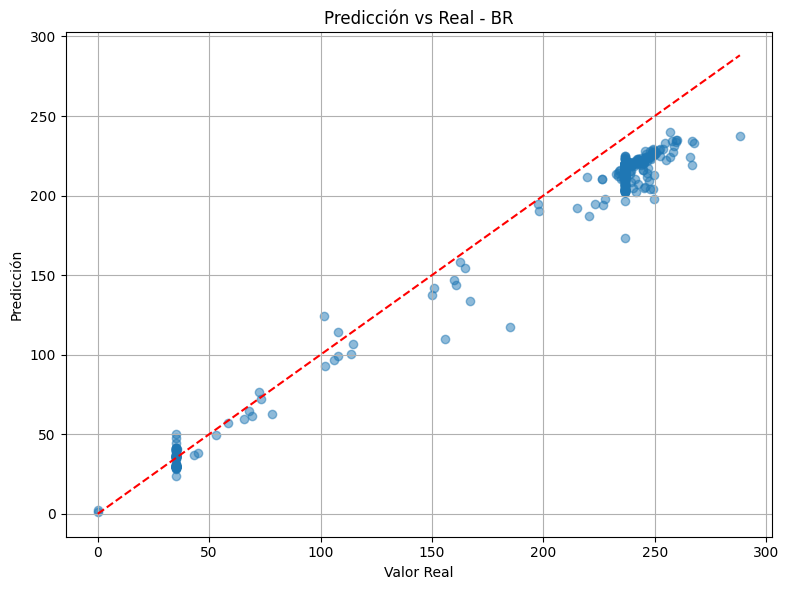

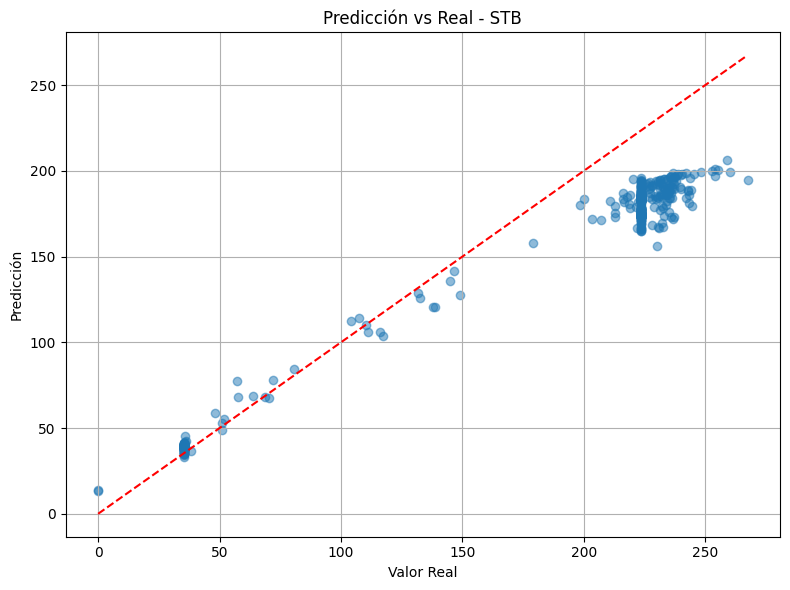

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from catboost import CatBoostRegressor

# Cargar modelos previamente entrenados
model_BR = CatBoostRegressor()
model_BR.load_model("modelo_reentrenado_BR.cbm")

model_STB = CatBoostRegressor()
model_STB.load_model("modelo_reentrenado_STB.cbm")

# Cargar nuevo dataset
df = pd.read_excel('NUAR-B_MARZO2025_CONVERTIO_2.xlsx', parse_dates=["DATE/TIME(America/Asuncion)"])


# PASANDO A datetime

df['DATE/TIME(America/Asuncion)'] = pd.to_datetime(df['DATE/TIME(America/Asuncion)'], errors='coerce')

# Extraer componentes de fecha
df['dia'] = df['DATE/TIME(America/Asuncion)'].dt.day
df['mes'] = df['DATE/TIME(America/Asuncion)'].dt.month
df['año'] = df['DATE/TIME(America/Asuncion)'].dt.year
df['hora'] = df['DATE/TIME(America/Asuncion)'].dt.hour
df['minuto'] = df['DATE/TIME(America/Asuncion)'].dt.minute
df['segundo'] = df['DATE/TIME(America/Asuncion)'].dt.second

df.drop(columns=['DATE/TIME(America/Asuncion)'], inplace=True)

# Separar entradas (X) y salidas (y)
X = df.drop(columns=["Flow Rate Prop. BR", "Flow Rate Prop. STB"])
y = df[["Flow Rate Prop. BR", "Flow Rate Prop. STB"]]

# Imputar valores nulos con la mediana
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
y_imputed = pd.DataFrame(imputer.fit_transform(y), columns=y.columns)

# Dividir en entrenamiento y prueba (mismo índice para ambos targets)
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.1, random_state=24)

y_train_BR = y_train["Flow Rate Prop. BR"]
y_test_BR = y_test["Flow Rate Prop. BR"]
y_train_STB = y_train["Flow Rate Prop. STB"]
y_test_STB = y_test["Flow Rate Prop. STB"]


# Predicciones con CatBoost (sin normalizar)
y_pred_BR = model_BR.predict(X_test)
y_pred_STB = model_STB.predict(X_test)

# Métricas de evaluación
def evaluar_modelo(y_real, y_pred, nombre):
    print(f"\n📊 Resultados para {nombre}:")
    print(f"MAE:  {mean_absolute_error(y_real, y_pred):.2f}")
    print(f"MSE:  {mean_squared_error(y_real, y_pred):.2f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_real, y_pred)):.2f}")
    print(f"R²:   {r2_score(y_real, y_pred):.4f}")

evaluar_modelo(y_test_BR, y_pred_BR, "Flow Rate Prop. BR")
evaluar_modelo(y_test_STB, y_pred_STB, "Flow Rate Prop. STB")

# Gráfico de predicciones vs reales
def graficar_resultados(y_real, y_pred, titulo):
    plt.figure(figsize=(8,6))
    plt.scatter(y_real, y_pred, alpha=0.5)
    plt.plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--')
    plt.xlabel("Valor Real")
    plt.ylabel("Predicción")
    plt.title(titulo)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

graficar_resultados(y_test_BR, y_pred_BR, "Predicción vs Real - BR")
graficar_resultados(y_test_STB, y_pred_STB, "Predicción vs Real - STB")
